## Gaussian Mixture Model

A Gaussian Micture Model for the credit card fraud problem

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
%matplotlib inline

import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,f1_score,recall_score,precision_score,accuracy_score,precision_recall_curve,roc_curve,roc_auc_score

from collections import Counter

from scipy.stats import norm, multivariate_normal

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(0)

In [6]:
def Print_Accuracy_Scores(y,y_pred):
    print("F1 Score: ", f1_score(y,y_pred))
    print("Precision Score: ", precision_score(y,y_pred))
    print("Recall Score: ", recall_score(y,y_pred))

In [7]:
#Loading Dataset
# UNCOMMENT ONE

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)
cc_dataset = pd.read_csv(path+"/creditcard.csv")

# Optional shrink for speed
#cc_dataset = cc_dataset.sample(frac = 0.2)

Path to dataset files: /Users/pewhite/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [8]:
cc_dataset.drop(labels = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8','Time'], axis = 1, inplace=True)
cc_dataset.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Amount', 'Class'],
      dtype='object')

In [9]:
cc_dataset.drop(labels = ['V1','V2','V5','V6','V7','V21','Amount'], axis = 1, inplace=True)
cc_dataset.columns

Index(['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18',
       'V19', 'Class'],
      dtype='object')

In [10]:
genuine_data = cc_dataset[cc_dataset['Class']==0]
fraud_data = cc_dataset[cc_dataset['Class']==1]

# optionally reduce data for speed
genuine_data = genuine_data.sample(frac=1, random_state=42)
fraud_data = fraud_data.sample(frac=1.0)

In [11]:
#Split Genuine records into train & test - 60:40 ratio
genuine_train,genuine_test = train_test_split(genuine_data,test_size=0.4,random_state=0)
print(genuine_train.shape)
print(genuine_test.shape)

(170589, 12)
(113726, 12)


In [12]:
#Split 40% of Genuine Test records into Cross Validation & Test again (50:50 ratio)
genuine_cv,genuine_test = train_test_split(genuine_test,test_size=0.5,random_state=0)
print(genuine_cv.shape)
print(genuine_test.shape)

(56863, 12)
(56863, 12)


In [13]:
#Split Fraud records into Cross Validation & Test (50:50 ratio)
fraud_cv,fraud_test = train_test_split(fraud_data,test_size=0.5,random_state=0)
print(fraud_cv.shape)
print(fraud_test.shape)

(246, 12)
(246, 12)


In [14]:
#Drop Y-label from Train data
train_data = genuine_train.drop(labels='Class',axis=1)
print(train_data.shape)

(170589, 11)


In [15]:
#Cross validation data
cv_data = pd.concat([genuine_cv,fraud_cv])
cv_data_y = cv_data['Class']
cv_data.drop(labels='Class',axis=1,inplace=True)
print(cv_data.shape)

(57109, 11)


In [16]:
#Test data
test_data = pd.concat([genuine_test,fraud_test])
test_data_y = test_data['Class']
test_data.drop(labels='Class',axis=1,inplace=True)
print(test_data.shape)

(57109, 11)


## The GMM Model

In [17]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Fit GMM to data (assuming 'data' contains normal instances)
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
gmm.fit(train_data)

,n_components,5
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,0


Text(0.5, 1.0, 'Log probabilities of training set')

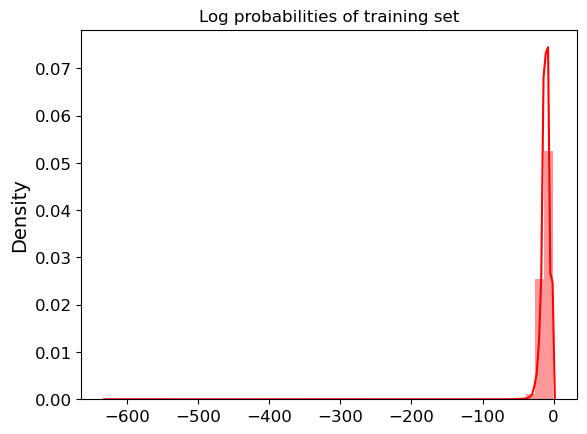

In [18]:
# Compute the log probability np.of each point
log_probs = gmm.score_samples(train_data)
sns.distplot(log_probs,color='r',label='Valid Class');
plt.title("Log probabilities of training set")

In [19]:
np.max(log_probs), np.min(log_probs)

(np.float64(-0.31373614987267157), np.float64(-630.5141446351537))

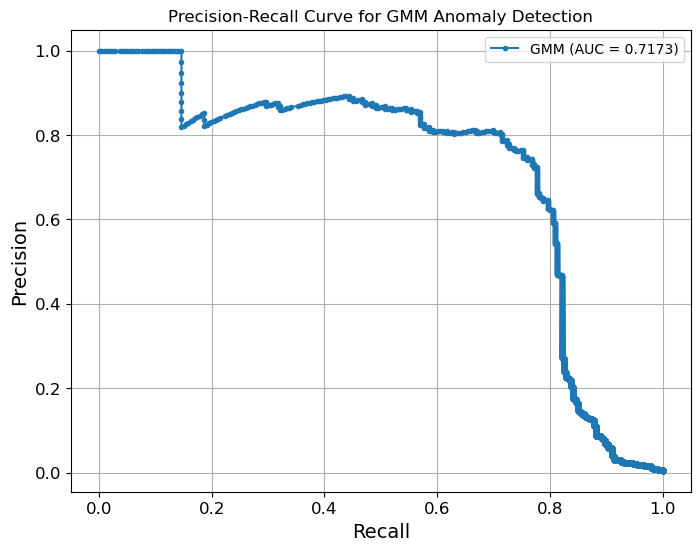

In [20]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Step 1: Compute log-likelihoods for validation data
log_probs_cv = gmm.score_samples(cv_data)  # log probabilities

# Step 2: Generate Precision-Recall data
# Use raw log probabilities as the "scores" for the classifier
precision, recall, thresholds = precision_recall_curve(cv_data_y, -log_probs_cv)
# Negative log_probs because lower values indicate anomalies

# Step 3: Compute the area under the PR curve
pr_auc = auc(recall, precision)

# Step 4: Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'GMM (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for GMM Anomaly Detection')
plt.legend()
plt.grid(True)
plt.show()


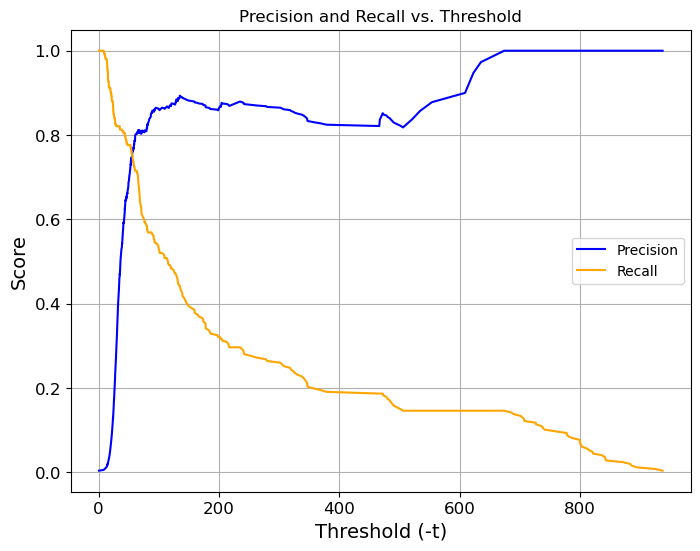

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Step 1: Compute log-likelihoods for validation data
log_probs_cv = gmm.score_samples(cv_data)  # log probabilities

# Step 2: Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(cv_data_y, -log_probs_cv)

# Step 3: Plot precision and recall vs. threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='orange')
plt.xlabel('Threshold (-t)')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

t =-100
print("t = ", t)

# Step 1: Compute log-likelihoods for validation data
log_probs_cv = gmm.score_samples(cv_data)  # log probabilities
log_probs_test = gmm.score_samples(test_data)

# Step 2: Classify based on threshold 't'
# Anomaly if log_prob < t → 1 (anomaly), else 0 (normal)
pred_cv = (log_probs_cv < t).astype(int)
pred_test = (log_probs_test < t).astype(int)

# Step 3: Calculate accuracy
accuracy = accuracy_score(cv_data_y, pred_cv)
f1 = f1_score(cv_data_y, pred_cv)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"F1 score: {f1:.4f}")

t =  -100
Model Accuracy: 0.9976
F1 score: 0.6549


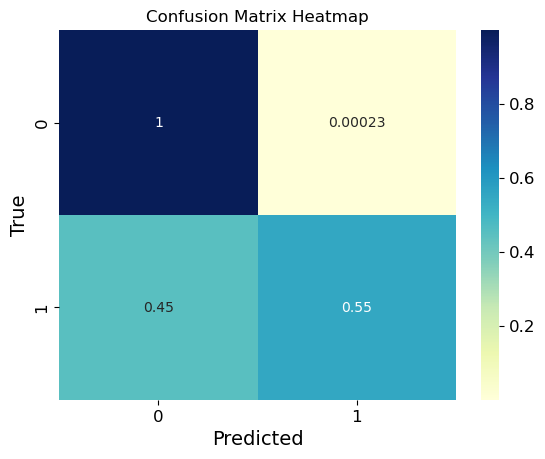

In [31]:
cnf_matrix = confusion_matrix(test_data_y, pred_test)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix  / row_sum
sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
plt.title("Normalized Confusion Matrix - Test data")
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')

# Display the plot
plt.title('Confusion Matrix Heatmap')
plt.show()

In [33]:
import numpy as np

# Assuming test_data_y and pred_test are numpy arrays or pandas Series
# Example: test_data_y = np.array([...]), pred_test = np.array([...])

# Compute counts for each category
TP = np.sum((test_data_y == 1) & (pred_test == 1))  # True positives
TN = np.sum((test_data_y == 0) & (pred_test == 0))  # True negatives
FP = np.sum((test_data_y == 0) & (pred_test == 1))  # False positives
FN = np.sum((test_data_y == 1) & (pred_test == 0))  # False negatives

P = np.sum((test_data_y==1))
N = np.sum((test_data_y==0))
LP = np.sum((pred_test == 1))
LN = np.sum((pred_test == 0))
# Total number of samples
total = len(test_data_y)

# Compute percentages
TP_percent = TP / total * 100
TN_percent = TN / total * 100
FP_percent = FP / total * 100
FN_percent = FN / total * 100

# Print the results
print(f"True Positives: {TP} / {P}")
print(f"False Negatives: {FN} / {P}")
print(f"True Negatives: {TN} / {N}")
print(f"False Positives: {FP} / {N}")

print(f"Power score: {(TP / FN):.4f}")

True Positives: 135 / 246
False Negatives: 111 / 246
True Negatives: 56850 / 56863
False Positives: 13 / 56863
Power score: 1.2162
